In [1]:
import subprocess

import matplotlib.pyplot as plt
import pandas as pd

In [38]:
!rm -r benchmark_output

In [37]:
base_cmd = (
    "glm_benchmarks_run --threads 6 --num_rows {n} --storage {s} "
    "--problem_name {p} --library_name {lib}"
)

problems = []
for p in ["narrow-insurance", "intermediate-insurance", "wide-insurance"]:
    for reg in ["l2", "lasso"]:
        for dist in ["tweedie-p=1.5", "poisson", "gaussian", "gamma", "binomial"]:
            problems.append(f"{p}-no-weights-{reg}-{dist}")

p = "intermediate-housing"
for reg in ["l2", "lasso"]:
    for dist in ["gaussian", "gamma", "binomial"]:
        problems.append(f"{p}-no-weights-{reg}-{dist}")

libraries = ["quantcore-glm", "r-glmnet", "h2o"]

n = 500000

# run r-glmnet and h2o benchmarks, sparse storage works best.
s = "sparse"
for lib in ["r-glmnet", "h2o"]:
    for p in problems:
        cmd = base_cmd.format(n=n, s=s, p=p, lib=lib)
        print(cmd)
        subprocess.run(cmd.split(" "))

# run quantcore-glm benchmarks where auto storage works best.
lib = "quantcore-glm"
s = "auto"
for p in problems:
    cmd = base_cmd.format(n=n, s=s, p=p, lib=lib)
    print(cmd)
    subprocess.run(cmd.split(" "))

analyze_cmd = "glm_benchmarks_analyze --export benchmark_data.csv"
subprocess.run(analyze_cmd.split(" "))

glm_benchmarks_run --threads 6 --num_rows 5000 --storage sparse --problem_name intermediate-housing-no-weights-l2-gaussian --library_name r-glmnet
running problem=intermediate-housing-no-weights-l2-gaussian library=r-glmnet


R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.1-2



ran problem intermediate-housing-no-weights-l2-gaussian with library r-glmnet
ran in 0.027112483978271484
glm_benchmarks_run --threads 6 --num_rows 5000 --storage sparse --problem_name intermediate-housing-no-weights-l2-gamma --library_name r-glmnet
running problem=intermediate-housing-no-weights-l2-gamma library=r-glmnet


R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.1-2



ran problem intermediate-housing-no-weights-l2-gamma with library r-glmnet
ran in 0.16353678703308105


R[write to console]: Warning message:

R[write to console]: thresh should be smaller than glmnet.control()$epsnr 



glm_benchmarks_run --threads 6 --num_rows 5000 --storage sparse --problem_name intermediate-housing-no-weights-l2-binomial --library_name r-glmnet


Traceback (most recent call last):
  File "/home/tbent/.miniconda3/envs/quantcore.glm/bin/glm_benchmarks_run", line 33, in <module>
    sys.exit(load_entry_point('quantcore.glm', 'console_scripts', 'glm_benchmarks_run')())
  File "/home/tbent/.miniconda3/envs/quantcore.glm/bin/glm_benchmarks_run", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/home/tbent/.miniconda3/envs/quantcore.glm/lib/python3.9/importlib/metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "/home/tbent/.miniconda3/envs/quantcore.glm/lib/python3.9/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<froze

KeyboardInterrupt: 

In [3]:
df = pd.read_csv("benchmark_data.csv")
df.drop(
    [
        "storage",
        "num_rows",
        "regularization_strength",
        "offset",
        "threads",
        "single_precision",
        "cv",
        "hessian_approx",
        "diagnostics_level",
    ],
    axis=1,
    inplace=True,
)
df["distribution"] = (
    df["problem_name"].str.split("-").apply(lambda x: x[-2] if "5" in x[-1] else x[-1])
)

In [4]:
%config InlineBackend.figure_format='retina'

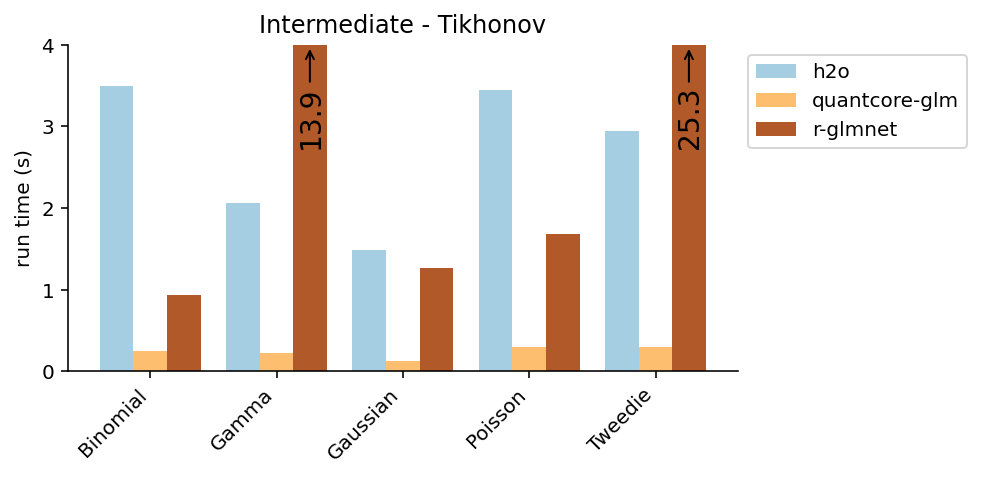

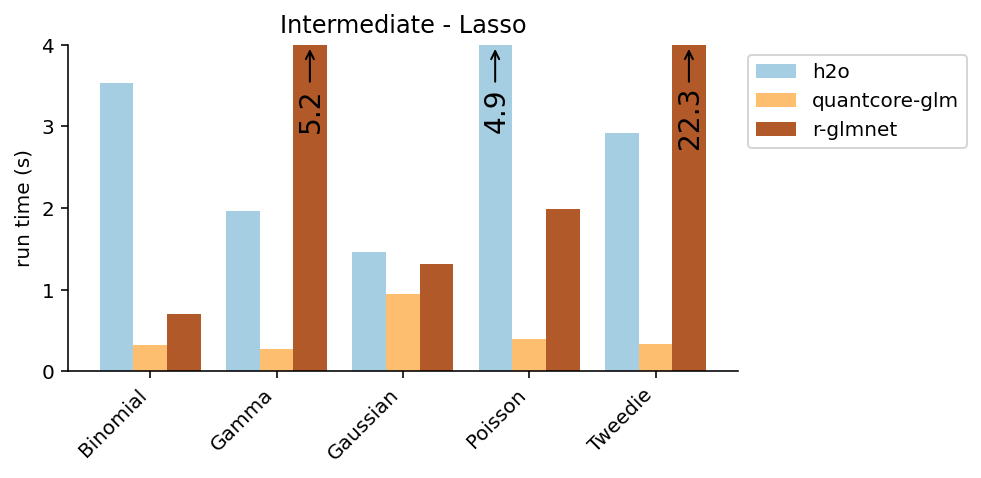

In [71]:
for prob_name in ["intermediate-insurance"]:  # "narrow", "intermediate"]:
    for reg in ["l2", "lasso"]:
        plot_df = (
            df[
                df["problem_name"].str.contains(reg)
                & df["problem_name"].str.contains(prob_name)
            ]
            .copy()
            .set_index(["distribution"])[["runtime", "library_name"]]
        )
        plot_df = plot_df.pivot(columns="library_name")
        plot_df.columns = plot_df.columns.get_level_values(1)
        plot_df.index = [x.title() for x in plot_df.index]

        title = prob_name.title() + " - " + ("Lasso" if reg == "lasso" else "Tikhonov")
        plot_df.plot.bar(
            ylim=[0, 4],
            title=title,
            legend=False,
            figsize=(6, 3),
            width=0.8,
            ylabel="run time (s)",
            yticks=[0, 1, 2, 3, 4],
            cmap="Paired",
        )
        plt.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=1)
        plt.xticks(rotation=45, ha="right")

        ax = plt.gca()

        # Hide the right and top spines
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position("left")
        ax.xaxis.set_ticks_position("bottom")

        for p in ax.patches:
            x = p.get_x()  # type: ignore
            y = p.get_height()  # type: ignore
            if y > 3.6:
                text_x = x + 0.03
                text_y = 2.8 if y > 10 else 3.0
                ax.annotate(
                    f"{y:.1f}",
                    (text_x, text_y),
                    fontsize=14,
                    rotation="vertical",
                )
                arrow_x = text_x + 0.10
                arrow_y = 3.5
                ax.annotate(
                    "",
                    xy=(arrow_x, arrow_y + 0.5),
                    xytext=(arrow_x, arrow_y),
                    arrowprops=dict(arrowstyle="->"),
                )

        fp = f"../_static/{prob_name}-{reg}.png"
        plt.savefig(fp, dpi=300)
        fp = f"../_static/{prob_name}-{reg}.pdf"
        plt.savefig(fp)
        plt.show()